This jupyter notebook shows different techniques to segement a .nii file. The data is the MRI of the lower back of a mouse. The goal is to retrieve the volume of the implant (a gel that was injected in its lower back). 

In  part 1, it is shown on a particular slice of the MRI (2d image) the different techniques such as :
- Otsu method (one threshold)
- Gamma correction
- Canny Edge detection
- Multithresh Otsu method  

In part 2, 4 methods that are combinations of part 1 are tested on the entire .nii file:
- MultiTresh Otsu and Edge Detection
- Gamma Correction and Edge Detection
- MultiTresh Otsu and Morphological Operations (best option)
- Gamma Correction and Morphological Operations

# 0. Import libraries and functions

In [2]:
import numpy as np

import scipy.ndimage as ndi
import SimpleITK as sitk

from PIL import Image

import matplotlib
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage import exposure

from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
from skimage.filters import sobel

from skimage.color import label2rgb

from skimage.feature import canny

from random import randrange
import nibabel as nib

from nibabel import Nifti1Header, Nifti1Image

import os
import ipywidgets as widgets

from skimage.feature import canny


In [3]:
# Calculating volume of implant
def volume_3d(image, s1, s2, s3):
    """
    Arguments:
        image - 3D image
        s1, s2, s3 - spacing by x, y and z axis --> s1*s2*s3 is voxel volume
        units - calculating number of voxels that are considered as implant
    """
    units = np.count_nonzero(image)
    return units * s1 * s2 * s3

In [4]:
# Implementation of widget for file browsing
class FileBrowser(object):
    def __init__(self):
        self.path = os.getcwd()
        self._update_files()

    def _update_files(self):
        self.files = list()
        self.dirs = list()
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = os.path.join(self.path, f)
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)

    def widget(self):
        box = widgets.VBox()
        self._update(box)
        return box

    def _update(self, box):

        def on_click(b):
            if b.description == '..':
                self.path = os.path.split(self.path)[0]
            else:
                self.path = os.path.join(self.path, b.description)
            self._update_files()
            self._update(box)

        buttons = []
        if self.files:
            button = widgets.Button(description='..', background_color='#d0d0ff', layout=widgets.Layout(width='50%'))
            button.on_click(on_click)
            buttons.append(button)
        for f in self.dirs:
            button = widgets.Button(description=f, background_color='#d0d0ff', layout=widgets.Layout(width='50%'))
            button.on_click(on_click)
            buttons.append(button)
        for f in self.files:
            button = widgets.Button(description=f, layout=widgets.Layout(width='50%'))
            button.on_click(on_click)
            buttons.append(button)
        box.children = tuple([widgets.HTML("<h2>%s</h2>" % (self.path,))] + buttons)

In [5]:
# Implementation of Gamma correction
def gamma_correction(image, gamma):
    
    """
    Arguments:
        image: input image 3D/2D image
        gamma: value of coefficient; gamma < 1 is called gamma compression
                                      gamma > 1 is called gamma expansion
    Returns:
        image_gamma (float): image after gamma transformation

    """
    m = np.min(image)
    M = np.max(image)
    
    # Image normalization to range [0, 1]
    image_norm = (image - m) / (M - m)
    image_norm = np.power(image_norm, gamma)
    
    image_gamma = image_norm*(M - m) + m
    return image_gamma

In [6]:
# Calculation of Dice coefficient
def dice_coefficient(prediction, mask):
    """
    Arguments:
        prediction: our prediction 
        mask: ground truth values
    -------------------------------------------------------------------------
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_coefficient (float): computed value of dice coefficient.     
    """
    
    epsilon = 0.0001
    den = 2*np.sum(prediction * mask) + epsilon
    nom = np.sum(prediction) + np.sum(mask) + epsilon
    return den/nom

# 1. Different techniques for segmentation (test on one slice)

## 1.1. Load MRI and its mask 

In [6]:
# Choosing image for segmentation
f = FileBrowser()
f.widget()


In [7]:
# Full path to chosen image
m.path

NameError: name 'm' is not defined

In [ ]:
# Catching spacing by axes for calculating volume

img = sitk.ReadImage(f.path)
spacing = img.GetSpacing()
spacing_x = spacing[0]
spacing_y = spacing[1]
spacing_z = spacing[2]

voxel_volume = spacing_x * spacing_y * spacing_z

spacing

(0.15625, 0.1302083283662796, 0.699999988079071)

In [ ]:
m = FileBrowser()
m.widget()

In [ ]:
# Catching image header for later mask saving with the same parameters 
nii_img = nib.load(f.path)
nii_header = nii_img.header
nii_affine = nii_img.affine

In [ ]:
print(nii_header['sform_code'])

1


In [ ]:
f.path

'/Users/julienadda/Desktop/projet_CIBM/CIBM_ImplantsData/Mice D1/Mouse 94.795 05082020/94-795G-D1-6.nii.gz'

In [7]:
path_image = '/Users/julienadda/Desktop/projet_CIBM/CIBM_ImplantsData/Mice D1/Mouse 94.795 05082020/Souris_94_795G_D1_Souris_94_795G_D1_6_1_1.nii'
path_mask = '/Users/julienadda/Desktop/projet_CIBM/CIBM_ImplantsData/Mice D1/Mouse 94.795 05082020/94-795G-D1-6.nii.gz'

Mouse = "94-791"
Time = "Day1"

# Load full MRI and mask
full_img = sitk.ReadImage(path_image)
spacing = full_img.GetSpacing()
full_img = sitk.GetArrayFromImage(full_img)

full_mask = sitk.ReadImage(path_mask)
full_mask = sitk.GetArrayFromImage(full_mask)


spacing_x = spacing[0]
spacing_y = spacing[1]
spacing_z = spacing[2]
voxel_volume = spacing_x * spacing_y * spacing_z
print("voxel_volume :", voxel_volume)

voxel_volume : 0.01424153567252992


Choose index for slicing (implant is located between: 14-42)

In [8]:
index = 23
image = full_img[index, :, :]
mask = full_mask[index, :, :]

## 1.2. Image loading, 23rd slice, histogram

- Why 23rd slice? $\rightarrow$ Idea behind choosing 23rd slice for thresholding came after analysing all 46 slices for whole data set, and realizing that for almost every instance, 23rd slice has biggest implant and when it comes to <i>seeking</i> peaks, the bigger implant, the higher peak


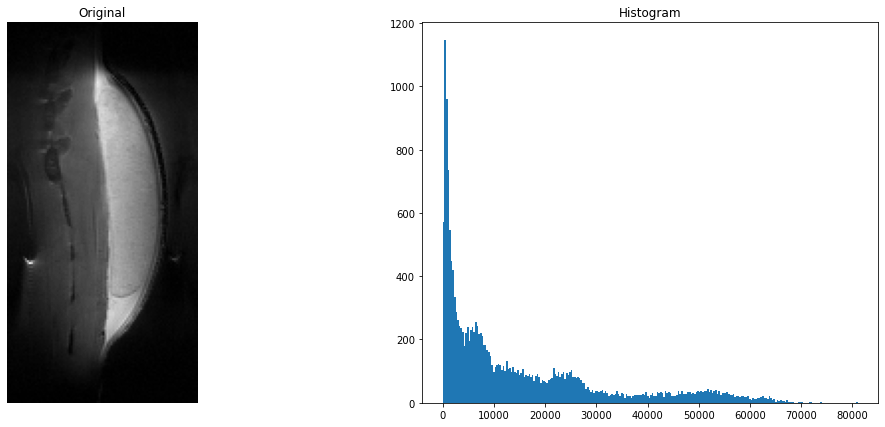

In [10]:
# Image loading, chosing 23rd slice as representative one
fig, axes = plt.subplots(ncols = 4, figsize=(18, 7))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins = 256)
ax[1].set_title('Histogram')

plt.show()

## 1.2. Otsu method (one threshold)

- We are maximizing inter-class variance (between-class)

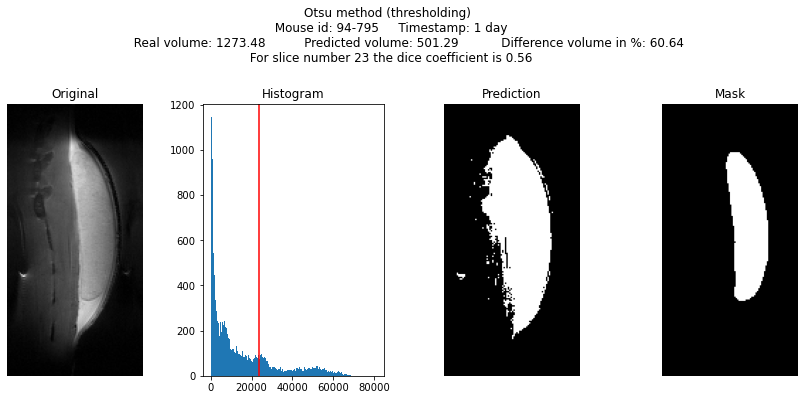

In [11]:
thresh = threshold_otsu(image)

p2, p98 = np.percentile(image, (10, 90))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
thresh_rescale = threshold_otsu(image_rescale)

binary = image > thresh

B = full_img > thresh

fig, axes = plt.subplots(ncols = 4, figsize=(15, 5))
ax = axes.ravel()

ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3)
ax[3] = plt.subplot(1, 4, 4, sharex = ax[0], sharey = ax[0])

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins = 256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Prediction')
ax[2].axis('off')

ax[3].imshow(mask, cmap=plt.cm.gray)
ax[3].set_title('Mask')
ax[3].axis('off')

real_volume = round(volume_3d(B, spacing_x, spacing_y, spacing_z),2)
predicted_volume =round(volume_3d(full_mask, spacing_x, spacing_y, spacing_z),2)
diff_volume = round(100*(real_volume-predicted_volume)/real_volume, 2)
plt.suptitle('Otsu method (thresholding) \n Mouse id: 94-795     Timestamp: 1 day\n          Real volume: {}          Predicted volume: {}           Difference volume in %: {}\n For slice number {} the dice coefficient is {}'.format(real_volume,predicted_volume,diff_volume,str(index), round(dice_coefficient(B.ravel(), full_mask.ravel()),2)), fontsize=12,y=1.15)
plt.show()

- Peak exists, but it is not clearly visible
- Idea $\rightarrow$ try to “shift the weight” and better express that peak

## 1.3. Gamma correction


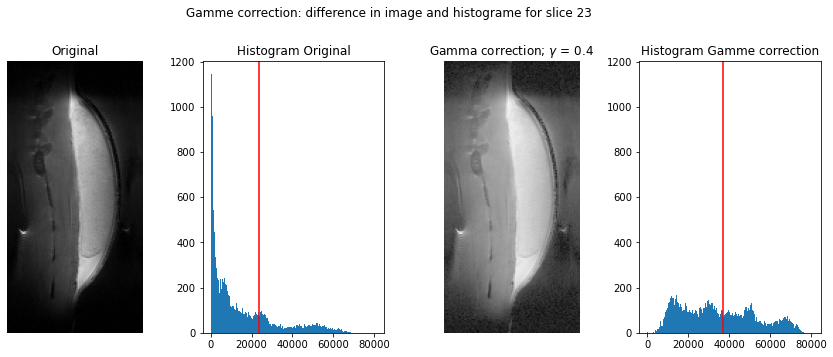

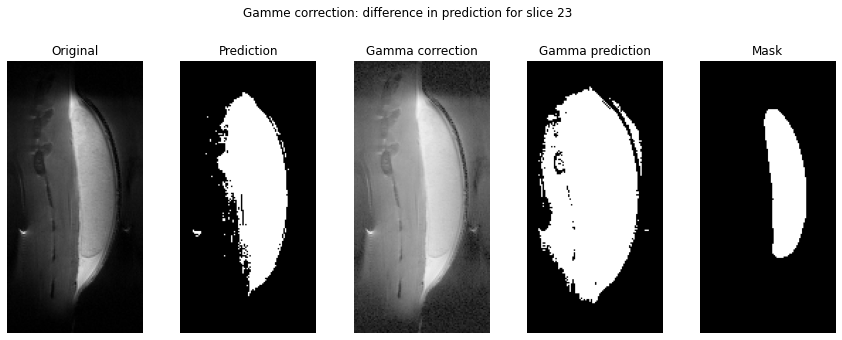

In [12]:
gamma = 0.4
image_gamma = gamma_correction(image, gamma)
thresh = threshold_otsu(image)
thresh_gamma = threshold_otsu(image_gamma)

binary = image > thresh
binary_gamma = image_gamma > thresh_gamma

fig, axes = plt.subplots(ncols = 4, figsize=(15, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3, sharex = ax[0], sharey = ax[0])
ax[3] = plt.subplot(1, 4, 4, sharey = ax[1])

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins = 256)
ax[1].set_title('Histogram Original')
ax[1].axvline(thresh, color='r')

ax[2].imshow(image_gamma, cmap = plt.cm.gray)
ax[2].set_title('Gamma correction; $\gamma$ = ' + str(gamma))
ax[2].axis('off')

ax[3].hist(image_gamma.ravel(), bins = 256)
ax[3].set_title('Histogram Gamme correction')
ax[3].axvline(thresh_gamma, color='r')

plt.suptitle("Gamme correction: difference in image and histograme for slice {}".format(str(index)),y=1.03)
plt.show()

fig, axes = plt.subplots(ncols = 5, figsize=(15, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 5, 1)
ax[1] = plt.subplot(1, 5, 2)
ax[2] = plt.subplot(1, 5, 3)
ax[3] = plt.subplot(1, 5, 4)
ax[4] = plt.subplot(1, 5, 5)

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary, cmap = plt.cm.gray)
ax[1].set_title('Prediction')
ax[1].axis('off')

ax[2].imshow(image_gamma, cmap = plt.cm.gray)
ax[2].set_title('Gamma correction')
ax[2].axis('off')

ax[3].imshow(binary_gamma, cmap = plt.cm.gray)
ax[3].set_title('Gamma prediction')
ax[3].axis('off')

ax[4].imshow(mask, cmap = plt.cm.gray)
ax[4].set_title('Mask')
ax[4].axis('off')

plt.suptitle("Gamme correction: difference in prediction for slice {}".format(str(index)),y=1.03)
plt.show()

In [13]:
B_g = full_img > thresh_gamma
print("Dice coefficient with gamma correction: ",dice_coefficient(B_g.ravel(), full_mask.ravel()))
print("Predicted volume with gamma correction: ",volume_3d(B_g, spacing_x, spacing_y, spacing_z))
print("Real volume: ",volume_3d(full_mask, spacing_x, spacing_y, spacing_z))

Dice coefficient with gamma correction:  0.748062015791083
Predicted volume with gamma correction:  747.9796950569439
Real volume:  501.2878141373807


## 1.4. Canny Edge detection


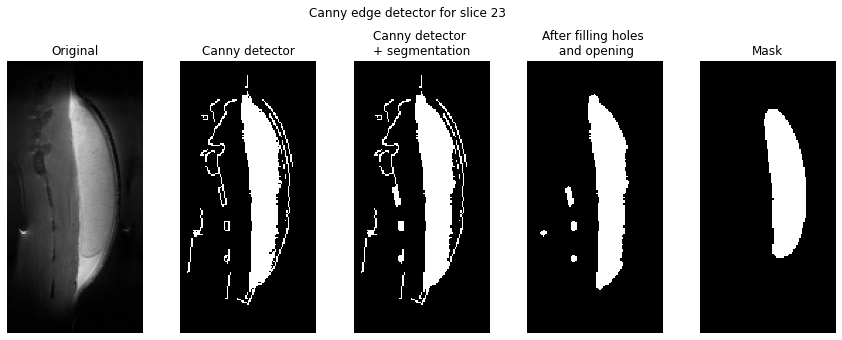

In [14]:
fig, axes = plt.subplots(ncols = 5, figsize=(15, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 5, 1)
ax[1] = plt.subplot(1, 5, 2)
ax[2] = plt.subplot(1, 5, 3)
ax[3] = plt.subplot(1, 5, 4)
ax[4] = plt.subplot(1, 5, 5)

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

image = ndi.median_filter(image, 3)
edges = canny(image/np.max(image))

fs = (10, 5)
a = np.logical_or(edges, B_g[index, :, :])

ax[1].imshow(a, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Canny detector')
ax[1].axis('off')

a = ndi.binary_fill_holes(a)

ax[2].imshow(a, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Canny detector \n+ segmentation')
ax[2].axis('off')

a = ndi.binary_opening(a, iterations = 1)

ax[3].imshow(a, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('After filling holes \n and opening')
ax[3].axis('off')

ax[4].imshow(mask, cmap = plt.cm.gray, interpolation='nearest')
ax[4].set_title('Mask')
ax[4].axis('off')

plt.suptitle("Canny edge detector for slice {}".format(str(index)),y=1.03)
plt.show()

## 1.5. Multithresh Otsu method 


- Idea is to try to separate data in more than 2 classes and to take the last threshold because this peak at very end exists, but it is not that visible

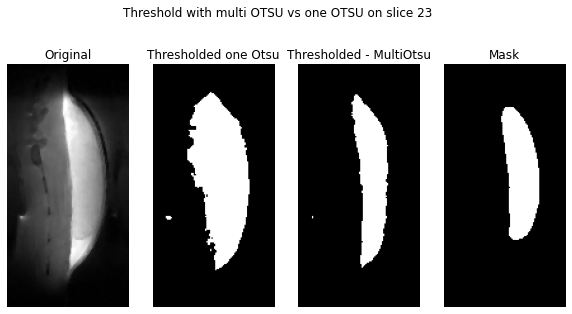

In [15]:
thresholds = threshold_multiotsu(image)
# Take last threshold
threshold = thresholds[-1]

image_mo = image > threshold
B_mo = full_img > threshold 

thresh = threshold_otsu(image)
image = image.astype(np.uint16)
p2, p98 = np.percentile(image, (10, 90))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
thresh_rescale = threshold_otsu(image_rescale)

binary = image > thresh

fig, axes = plt.subplots(ncols = 4, figsize=(10, 5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2, sharex = ax[0], sharey = ax[0])
ax[2] = plt.subplot(1, 4, 3, sharex = ax[0], sharey = ax[0])
ax[3] = plt.subplot(1, 4, 4, sharex = ax[0], sharey = ax[0])

ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Thresholded one Otsu')
ax[1].axis('off')

ax[2].imshow(image_mo, cmap=plt.cm.gray)
ax[2].set_title('Thresholded - MultiOtsu')
ax[2].axis('off')

ax[3].imshow(mask, cmap=plt.cm.gray)
ax[3].set_title('Mask')
ax[3].axis('off')

plt.suptitle("Threshold with multi OTSU vs one OTSU on slice " + str(index),y=1)

plt.show()

# 2. Full pipeline (test on full MRI)

## 2.1 MultiTresh Otsu and Edge Detection

Calculated Volume is: 1035.6017494993582 μm^3, and the Mask Volume is: 501.2878141373807 μm^3


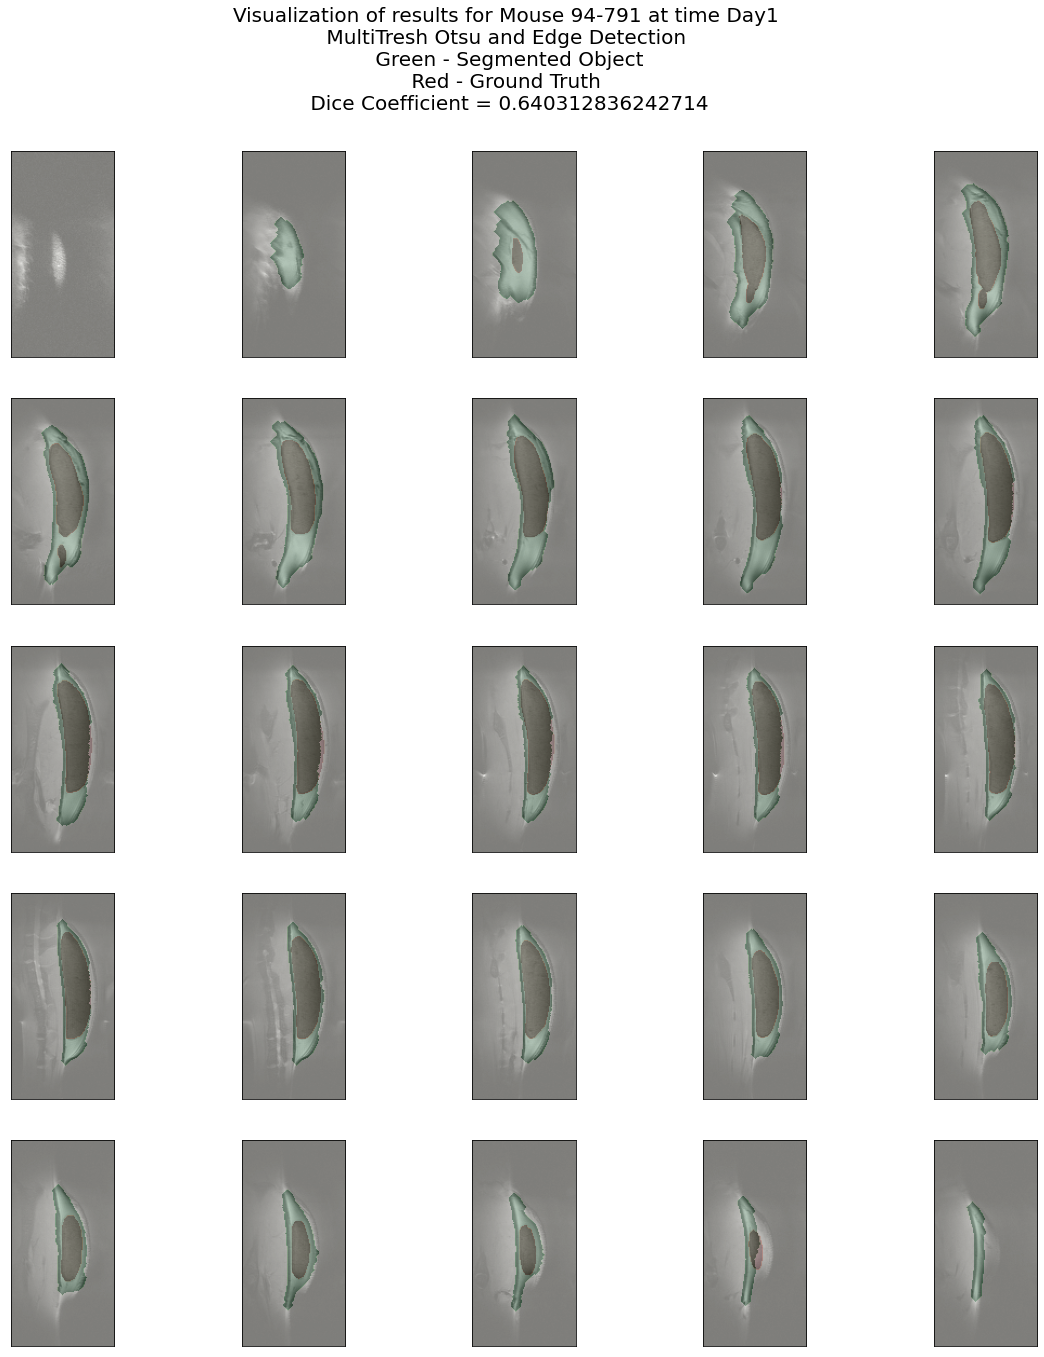

In [19]:
start_plot = 10
end_plot = 35
Nslices_plot = end_plot - start_plot
grid_width = 5
grid_height = int(np.ceil(Nslices_plot/grid_width))

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
fig.subplots_adjust(bottom = 0.05)
C = []

thresholds = threshold_multiotsu(image)
# Take last threshold
threshold = thresholds[-1]

image_mo = image > threshold
B_mo = full_img > threshold 

for i in range(full_img.shape[0]):
    img = full_img[i, :, :]
    img = ndi.median_filter(img, 3)
    edges = canny(img/np.max(img))

    a = np.logical_or(edges, B_mo[i, :, :])
    a = ndi.binary_fill_holes(a)
    a = ndi.binary_opening(a, iterations = 2)

    label_mask, num_features = ndi.label(a)

    sizes = np.bincount(label_mask.ravel())
    sort = np.sort(sizes)
    sort_flip = np.flip(sort)
    
    if (sort_flip.shape == (1,) or np.sum(B_mo[i, :, :]) < 100):
        mask_c = np.zeros(label_mask.shape)
    else:
        mask_s = sizes == sort_flip[1]
        mask_c = mask_s[label_mask]
        
    overlay = np.where(mask_c > 0, mask_c, 0)

    c = ndi.binary_closing(overlay, iterations = 10)
    # c1 = ndi.binary_erosion(c, iterations = 2)
    c1 = ndi.binary_dilation(c, iterations = 2)
    C.append(c1)
    
segmentation = np.array(C)

for i in range(Nslices_plot):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(full_img[i + start_plot, :, :], cmap = 'gray')
    ax.imshow(full_mask[i + start_plot, :, :], cmap = 'Reds', alpha = 0.3) 
    ax.imshow(segmentation[i + start_plot, :, :], cmap = 'Greens', alpha = 0.3)      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

string = 'Mouse {} at time {}'.format(Mouse, Time)
DC = dice_coefficient(segmentation.ravel(), full_mask.ravel())
method = "MultiTresh Otsu and Edge Detection"
plt.suptitle("Visualization of results for " + string + 
             "\n MultiTresh Otsu and Edge Detection "+"\n Green - Segmented Object" +
             "\n Red - Ground Truth \n Dice Coefficient = " + str(DC), fontsize=20)

V = volume_3d(segmentation, spacing_x, spacing_y, spacing_z)
V_m = volume_3d(full_mask, spacing_x, spacing_y, spacing_z)
print("Calculated Volume is: " + str(V) + " \u03BC"+"m^3, and the Mask Volume is: " + str(V_m) + " \u03BC"+"m^3")

plt.show()

## 2.2. Gamma Correction and Edge Detection

Calculated Volume is: 1008.4288994361712 μm^3, and the Mask Volume is: 501.2878141373807 μm^3


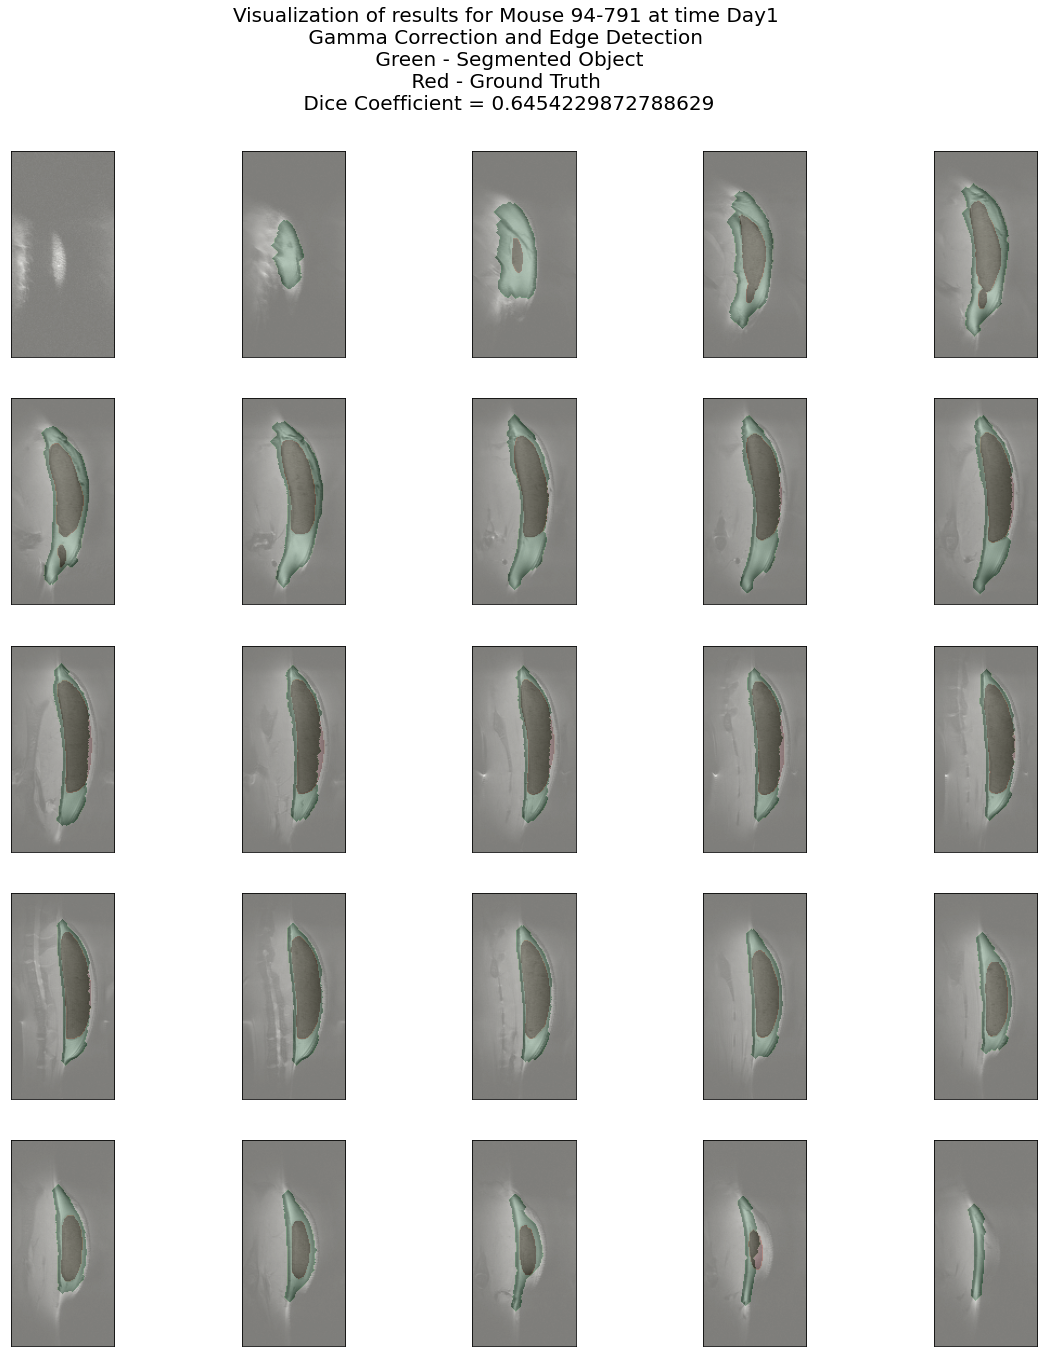

In [18]:
start_plot = 10
end_plot = 35
Nslices_plot = end_plot - start_plot
grid_width = 5
grid_height = int(np.ceil(Nslices_plot/grid_width))

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
fig.subplots_adjust(bottom = 0.05)
C = []

gamma = 0.4
image_gamma = gamma_correction(image, gamma)
thresh_gamma = threshold_otsu(image_gamma)
B_g = full_img > thresh_gamma


for i in range(full_img.shape[0]):
    img = full_img[i, :, :]
    img = ndi.median_filter(img, 3)
    edges = canny(img/np.max(img))

    a = np.logical_or(edges, B_g[i, :, :])
    a = ndi.binary_fill_holes(a)
    a = ndi.binary_opening(a, iterations = 2)

    label_mask, num_features = ndi.label(a)

    sizes = np.bincount(label_mask.ravel())
    sort = np.sort(sizes)
    sort_flip = np.flip(sort)
    
    if (sort_flip.shape == (1,) or np.sum(B_mo[i, :, :]) < 100):
        mask_c = np.zeros(label_mask.shape)
    else:
        mask_s = sizes == sort_flip[1]
        mask_c = mask_s[label_mask]
        
    overlay = np.where(mask_c > 0, mask_c, 0)

    c = ndi.binary_closing(overlay, iterations = 10)
    # c1 = ndi.binary_erosion(c, iterations = 2)
    c1 = ndi.binary_dilation(c, iterations = 2)
    C.append(c1)
    
segmentation = np.array(C)

for i in range(Nslices_plot):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(full_img[i + start_plot, :, :], cmap = 'gray')
    ax.imshow(full_mask[i + start_plot, :, :], cmap = 'Reds', alpha = 0.3) 
    ax.imshow(segmentation[i + start_plot, :, :], cmap = 'Greens', alpha = 0.3)      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

string = 'Mouse {} at time {}'.format(Mouse, Time)
DC = dice_coefficient(segmentation.ravel(), full_mask.ravel())
method = "Gamma Correction and Edge Detection"
plt.suptitle("Visualization of results for " + string + 
             "\n Gamma Correction and Edge Detection "+"\n Green - Segmented Object" +
             "\n Red - Ground Truth \n Dice Coefficient = " + str(DC), fontsize=20)


V = volume_3d(segmentation, spacing_x, spacing_y, spacing_z)
V_m = volume_3d(full_mask, spacing_x, spacing_y, spacing_z)

print("Calculated Volume is: " + str(V) + " \u03BC"+"m^3, and the Mask Volume is: " + str(V_m) + " \u03BC"+"m^3")


## 2.3. MultiTresh Otsu and Morphological Operations

Calculated Volume is: 581.2255538672911 μm^3, and the Mask Volume is: 501.2878141373807 μm^3


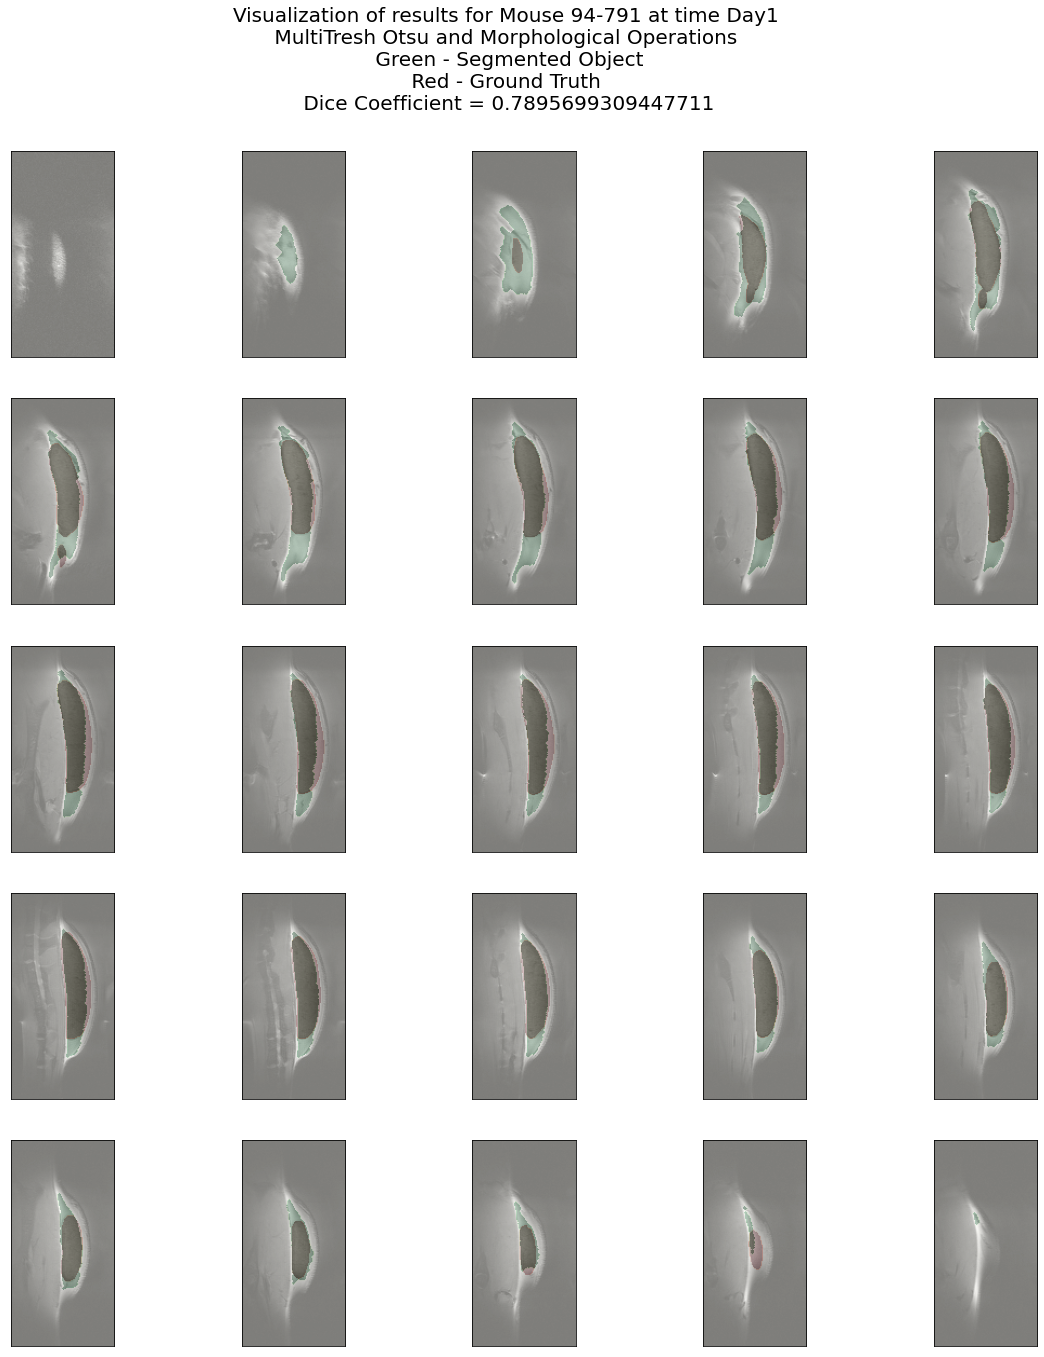

In [17]:
start_plot = 10
end_plot = 35
Nslices_plot = end_plot - start_plot
grid_width = 5
grid_height = int(np.ceil(Nslices_plot/grid_width))

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
fig.subplots_adjust(bottom = 0.05)
C = []

thresholds = threshold_multiotsu(image)
# Take last threshold
threshold = thresholds[-1]

image_mo = image > threshold
B_mo = full_img > threshold 

for i in range(full_img.shape[0]):
    
    a = ndi.binary_fill_holes(B_mo[i, :, :])
    a = ndi.binary_opening(a, iterations = 3)

    label_mask, num_features = ndi.label(a)

    sizes = np.bincount(label_mask.ravel())
    sort = np.sort(sizes)
    sort_flip = np.flip(sort)
    
    if (sort_flip.shape == (1,) or np.sum(B_mo[i, :, :]) < 100):
        mask_c = np.zeros(label_mask.shape)
    else:
        mask_s = sizes == sort_flip[1]
        mask_c = mask_s[label_mask]
    overlay = np.where(mask_c > 0, mask_c, 0)
    
    c = ndi.binary_closing(overlay, iterations = 1)
    c1 = ndi.binary_erosion(c, iterations = 2)
    #c1 = ndi.binary_dilation(c, iterations = 2)
    C.append(c1)
    
segmentation = np.array(C)

for i in range(Nslices_plot):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(full_img[i + start_plot, :, :], cmap = 'gray')
    ax.imshow(full_mask[i + start_plot, :, :], cmap = 'Reds', alpha = 0.3) 
    ax.imshow(segmentation[i + start_plot, :, :], cmap = 'Greens', alpha = 0.3)      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
string = 'Mouse {} at time {}'.format(Mouse, Time)
DC = dice_coefficient(segmentation.ravel(), full_mask.ravel())
method = "MultiTresh Otsu and Morphological Operations"
plt.suptitle("Visualization of results for " + string + 
             "\n MultiTresh Otsu and Morphological Operations "+"\n Green - Segmented Object" +
             "\n Red - Ground Truth \n Dice Coefficient = " + str(DC), fontsize=20)

V = volume_3d(segmentation, spacing_x, spacing_y, spacing_z)
V_m = volume_3d(full_mask, spacing_x, spacing_y, spacing_z)

print("Calculated Volume is: " + str(V) + " \u03BC"+"m^3, and the Mask Volume is: " + str(V_m) + " \u03BC"+"m^3")
plt.show()

## 2.4. Gamma Correction and Morphological Operations

Calculated Volume is: 846.502638839506 μm^3, and the Mask Volume is: 501.2878141373807 μm^3


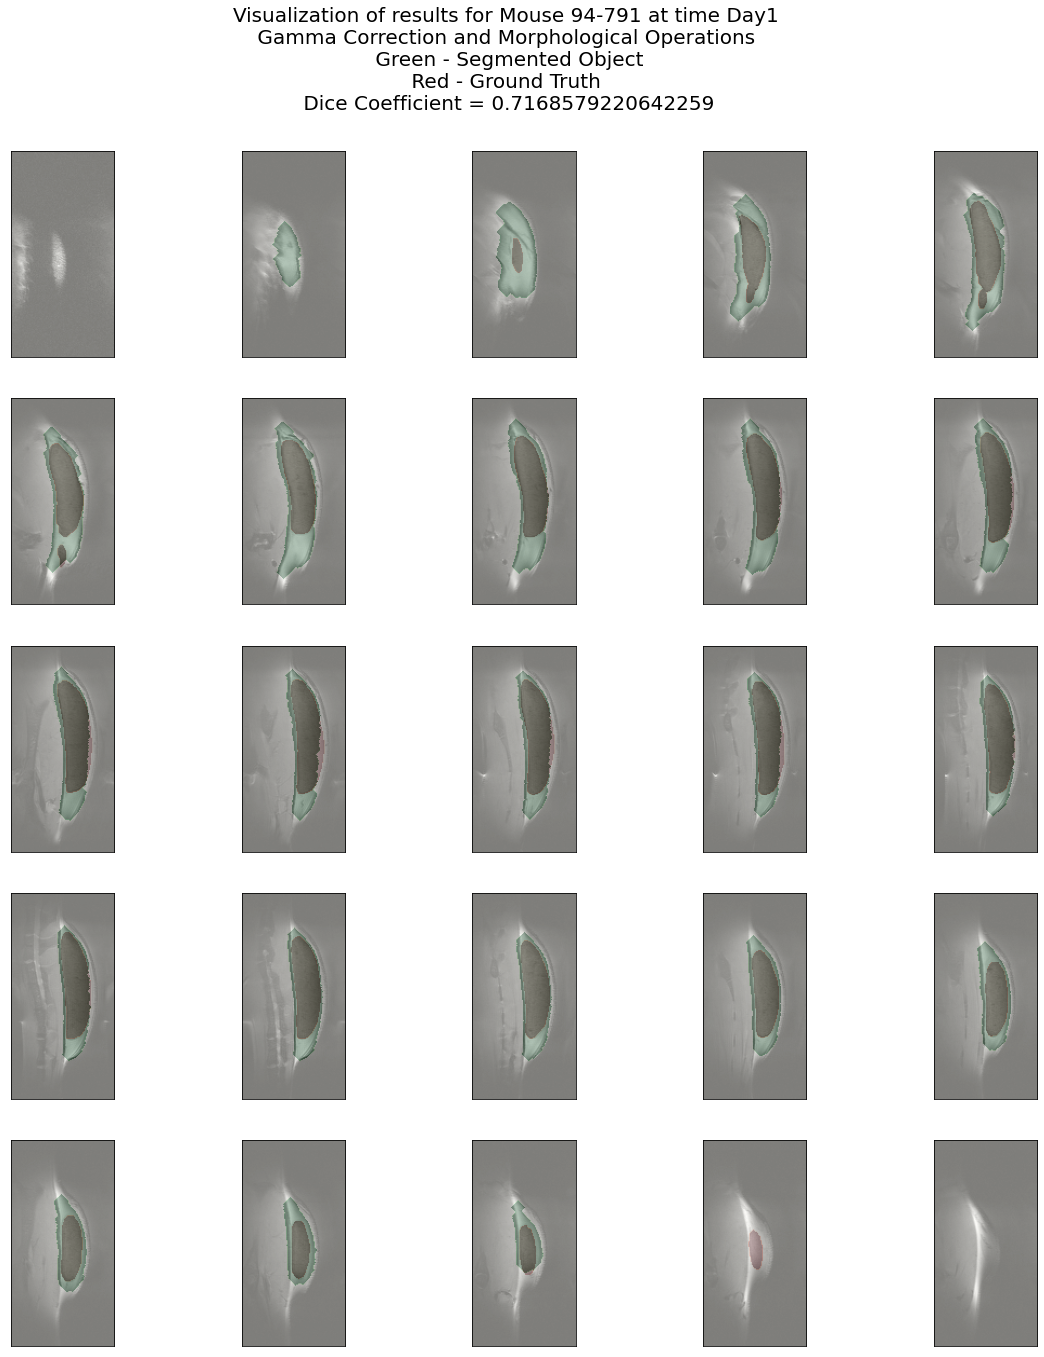

In [16]:
start_plot = 10
end_plot = 35
Nslices_plot = end_plot - start_plot
grid_width = 5
grid_height = int(np.ceil(Nslices_plot/grid_width))

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
fig.subplots_adjust(bottom = 0.05)
C = []

gamma = 0.4
image_gamma = gamma_correction(image, gamma)
thresh_gamma = threshold_otsu(image_gamma)
B_g = full_img > thresh_gamma

for i in range(full_img.shape[0]):
    
    a = ndi.binary_fill_holes(B_g[i, :, :])
    a = ndi.binary_opening(a, iterations = 4)

    label_mask, num_features = ndi.label(a)

    sizes = np.bincount(label_mask.ravel())
    sort = np.sort(sizes)
    sort_flip = np.flip(sort)
    
    if (sort_flip.shape == (1,) or np.sum(B_mo[i, :, :]) < 100):
        mask_c = np.zeros(label_mask.shape)
    else:
        mask_s = sizes == sort_flip[1]
        mask_c = mask_s[label_mask]
    overlay = np.where(mask_c > 0, mask_c, 0)

    c = ndi.binary_closing(overlay, iterations = 10)
    # c1 = ndi.binary_erosion(c, iterations = 2)
    c1 = ndi.binary_dilation(c, iterations = 2)
    C.append(c1)
    
segmentation = np.array(C)

for i in range(Nslices_plot):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(full_img[i + start_plot, :, :], cmap = 'gray')
    ax.imshow(full_mask[i + start_plot, :, :], cmap = 'Reds', alpha = 0.3) 
    ax.imshow(segmentation[i + start_plot, :, :], cmap = 'Greens', alpha = 0.3)      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
string = 'Mouse {} at time {}'.format(Mouse, Time)
DC = dice_coefficient(segmentation.ravel(), full_mask.ravel())
method = "Gamma Correction and Morphological Operations"
plt.suptitle("Visualization of results for " + string + 
             "\n Gamma Correction and Morphological Operations "+"\n Green - Segmented Object" +
             "\n Red - Ground Truth \n Dice Coefficient = " + str(DC), fontsize=20)


V = volume_3d(segmentation, spacing_x, spacing_y, spacing_z)
V_m = volume_3d(full_mask, spacing_x, spacing_y, spacing_z)

print("Calculated Volume is: " + str(V) + " \u03BC"+"m^3, and the Mask Volume is: " + str(V_m) + " \u03BC"+"m^3")
plt.show()